# Description

This notebook implements a Decision Tree for classification of the Distracted Driver Dataset.
No feature engineering has been conducted.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import cv2

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from skimage import filters

## Consolidating Training Data

In [18]:
# Paths to training dataset and test dataset

class_nums = [f'c{i}' for i in range(8)]
path_combined_dataset = os.path.join('Distracted Driver Dataset', 'Combined New')
# path_combined_dataset = os.path.join('Distracted Driver Dataset', 'Combined') # Old
paths_class_train = [os.path.join(path_combined_dataset, 'train', num) for num in class_nums]
paths_class_test = [os.path.join(path_combined_dataset, 'test', num) for num in class_nums]
paths_class_unseen = [os.path.join(path_combined_dataset, 'unseen', num) for num in class_nums]

In [20]:
# Finding out the original sizes of the images

num_total_files = []
possible_shapes = dict({})
for path in paths_class_train:
    files = sorted(glob.glob(os.path.join(path,'*')))
    for file in files:
        img = plt.imread(file)
        if img.shape in possible_shapes:
            possible_shapes[img.shape] += 1
        else:
            possible_shapes[img.shape] = 1

possible_shapes

{(1080, 1920, 3): 10555, (480, 640, 3): 2000}

In [3]:
# Getting training data

X_train, Y_train = [],[]

desired_dim = (100,100) # Change this as desired

for path in paths_class_train:
    files = glob.glob(os.path.join(path,'*'))
    label = path.split(os.path.sep)[-1]

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        if img.shape != desired_dim:
            img = cv2.resize(img, desired_dim)
        X_train.append(img)
        Y_train.append(label)

In [5]:
# Getting test data

X_names, X_test, Y_test = [],[],[]

print(f'Desired dimensions: {desired_dim}') # check if they are the same as X_train and Y_train

for path in paths_class_test:
    files = glob.glob(os.path.join(path,'*'))
    label = path.split(os.path.sep)[-1]

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        if img.shape != desired_dim:
            img = cv2.resize(img, desired_dim)
        X_names.append(os.path.join(label,file.split(os.path.sep)[-1]))
        X_test.append(img)
        Y_test.append(label)

Desired dimensions: (100, 100)


In [20]:
# Getting unseen data

X_unseen, Y_unseen = [],[]

print(f'Desired dimensions: {desired_dim}') # check if they are the same as X_train and Y_train

for path in paths_class_unseen:
    files = glob.glob(os.path.join(path,'*'))
    label = path.split(os.path.sep)[-1]

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        if img.shape != desired_dim:
            img = cv2.resize(img, desired_dim)
        X_unseen.append(img)
        Y_unseen.append(label)

Desired dimensions: (100, 100)


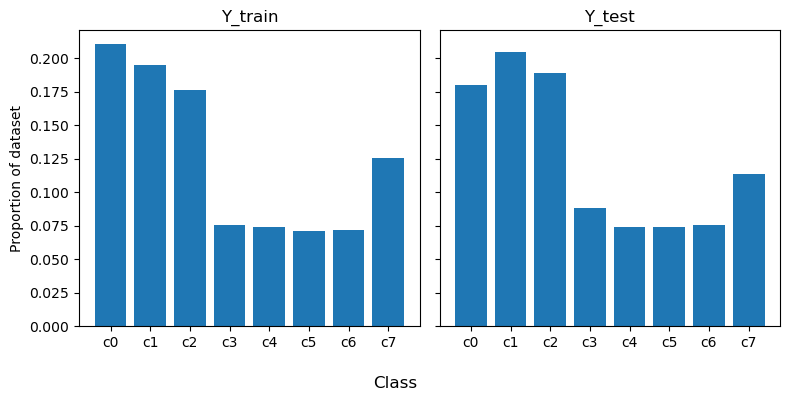

In [11]:
# Distribution of classes in Y_train vs Y_test

y_train_vals,y_train_counts = np.unique(Y_train, return_counts=True)
y_test_vals,y_test_counts = np.unique(Y_test, return_counts=True)

# Normalizing
y_train_counts = np.array(y_train_counts)/sum(y_train_counts)
y_test_counts = np.array(y_test_counts)/sum(y_test_counts)

fig,ax=plt.subplots(ncols=2, sharey=True, figsize=(8,4))
ax[0].bar(x=y_train_vals, height=y_train_counts)
ax[0].set_title('Y_train')
ax[0].set_ylabel('Proportion of dataset')

ax[1].bar(x=y_test_vals, height=y_test_counts)
ax[1].set_title('Y_test')

fig.supxlabel('Class')

plt.tight_layout()
plt.show()

In [6]:
# Trying out undersampling to balance out classes

y_train_vals,y_train_counts = np.unique(Y_train, return_counts=True)
sample_size = np.min(y_train_counts)
print(f'Sample size: {sample_size}')

indices_dict = dict({}) # to store the start and end index for each class in the Y_train array so we can sample

start, end = -1, -1
curr_label = 0
for i in range(len(Y_train)):
    if Y_train[i] == f'c{curr_label}':
        if start == -1:
            start = i
        continue
    end = i
    indices_dict[f'c{curr_label}'] = [start,end]
    start, end = i, -1
    curr_label += 1
indices_dict[f'c{curr_label}'] = [start,i+1]

Sample size: 723


In [32]:
indices_dict # end is exclusive

{'c0': [0, 2640],
 'c1': [2640, 5089],
 'c2': [5089, 7301],
 'c3': [7301, 8254],
 'c4': [8254, 9187],
 'c5': [9187, 10078],
 'c6': [10078, 10976],
 'c7': [10976, 12555]}

In [7]:
# Sampling the indices
sample_indices = []

for label in indices_dict.keys():
    start,end = indices_dict[label]
    sample = np.random.choice(list(range(start,end)), size=sample_size, replace=False)
    sample_indices = np.concatenate((sample_indices, sample))
    
print(f'Size of sampled dataset: {len(sample_indices)}')

Size of sampled dataset: 5784


In [8]:
# Generating a sampled dataset using indices
sample_indices = sample_indices.astype('int')

X_train_s = [X_train[i] for i in sample_indices]
Y_train_s = [Y_train[i] for i in sample_indices]

np.unique(Y_train_s, return_counts=True)

(array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7'], dtype='<U2'),
 array([723, 723, 723, 723, 723, 723, 723, 723]))

## Visualizing effects of preprocessing

In [485]:
# Trying out GrabCut - used by one of the papers that also used this AUC dataset
image = X_train_s[0]
#image = X_train_s[891*4+650]

rect = (1,1,100,100)
mask = np.zeros(image.shape[:2],np.uint8)
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")

mask, bgM, fgM = cv2.grabCut(image, mask, rect, bgModel, fgModel, iterCount=5, mode=cv2.GC_INIT_WITH_RECT)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
image_2 = image*mask[:,:,np.newaxis]
image_3 = filters.sobel(cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY))

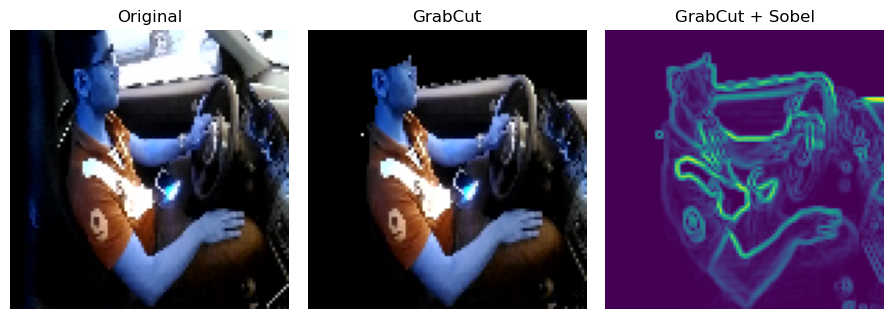

In [486]:
images = [image, image_2, image_3]
labels = ['Original', 'GrabCut', 'GrabCut + Sobel']

fig,ax = plt.subplots(ncols=3, figsize=(9,3))

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')
    
plt.tight_layout(pad=.5)
plt.show()

## Applying preprocessing to dataset

In [12]:
# Applies GrabCut to isolate foreground then applies sobel edge detection filter to get edges
def grabcut_sobel(image):
    rect = (1,1,100,100)
    mask = np.zeros(image.shape[:2],np.uint8)
    fgModel = np.zeros((1, 65), dtype="float")
    bgModel = np.zeros((1, 65), dtype="float")
    mask, bgM, fgM = cv2.grabCut(image, mask, rect, bgModel, fgModel, iterCount=5, mode=cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    image = image * mask[:,:,np.newaxis]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = filters.sobel(image)
    
    return image

In [25]:
# To get minimally preprocessed data
X_train_gray = []
for image in X_train_s:
    filter_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    X_train_gray.append(filter_img.flatten())
    
X_test_gray = []
for image in X_test:
    filter_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    X_test_gray.append(filter_img.flatten())
    
X_unseen_gray = []
for image in X_unseen:
    filter_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    X_unseen_gray.append(filter_img.flatten())

In [13]:
# To get data preprocessed using GrabCut and Sobel filter
X_train_preprocess = []
for image in X_train_s:
    filter_img = grabcut_sobel(image)
    X_train_preprocess.append(filter_img.flatten())
    
X_test_preprocess = []
for image in X_test:
    filter_img = grabcut_sobel(image)
    X_test_preprocess.append(filter_img.flatten())
    
X_unseen_preprocess = []
for image in X_unseen:
    filter_img = grabcut_sobel(image)
    X_unseen_preprocess.append(filter_img.flatten())

## Model

### New train-test split

In [14]:
dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=35)
# Tuned hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}

In [15]:
# New train-test split
dt.fit(X_train_preprocess, Y_train_s)
Y_pred = dt.predict(X_test_preprocess)
accuracy_score(Y_test, Y_pred)

0.6323960164030463

In [24]:
# New train-test split, unseen data
Y_unseen_pred = dt.predict(X_unseen_preprocess)
accuracy_score(Y_unseen, Y_unseen_pred)

0.18474374255065554

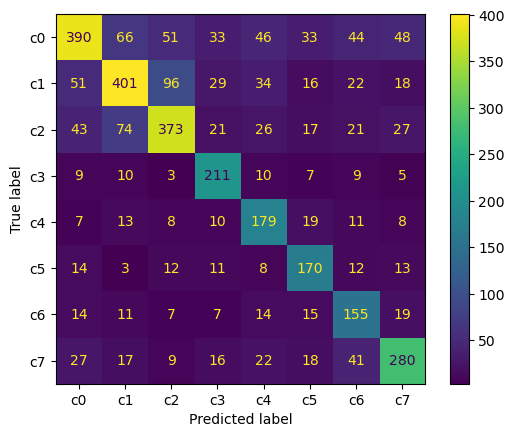

In [26]:
# New train-test split
cm = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(cm, display_labels=dt.classes_).plot()

In [27]:
# New train-test split
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          c0       0.70      0.55      0.62       711
          c1       0.67      0.60      0.64       667
          c2       0.67      0.62      0.64       602
          c3       0.62      0.80      0.70       264
          c4       0.53      0.70      0.60       255
          c5       0.58      0.70      0.63       243
          c6       0.49      0.64      0.56       242
          c7       0.67      0.65      0.66       430

    accuracy                           0.63      3414
   macro avg       0.62      0.66      0.63      3414
weighted avg       0.64      0.63      0.63      3414



### Old train-test split

In [374]:
# Old train-test split
dt.fit(X_train_preprocess, Y_train_s)
Y_pred = dt.predict(X_test_preprocess)
accuracy_score(Y_test, Y_pred)

0.23400936037441497

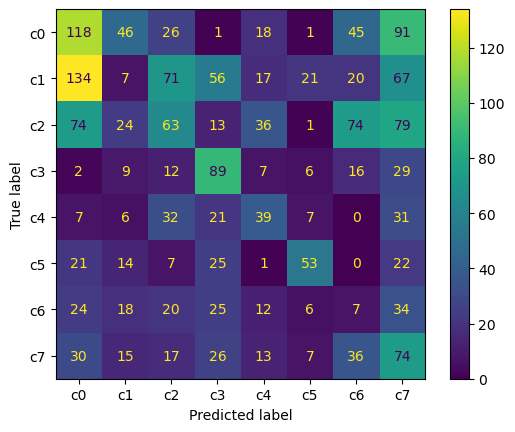

In [379]:
# Old train-test split
cm = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(cm, display_labels=dt.classes_).plot()

In [377]:
# Old train-test split
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          c0       0.29      0.34      0.31       346
          c1       0.05      0.02      0.03       393
          c2       0.25      0.17      0.21       364
          c3       0.35      0.52      0.42       170
          c4       0.27      0.27      0.27       143
          c5       0.52      0.37      0.43       143
          c6       0.04      0.05      0.04       146
          c7       0.17      0.34      0.23       218

    accuracy                           0.23      1923
   macro avg       0.24      0.26      0.24      1923
weighted avg       0.22      0.23      0.22      1923



## Comparing performance of model with minimally processed vs preprocessed data

### New train-test split

In [28]:
# Repeating multiple times to get the average accuracy for preprocessed data

acc_preprocess = []

for i in range(10):
    dt.fit(X_train_preprocess, Y_train_s)
    Y_pred = dt.predict(X_test_preprocess)
    acc_preprocess.append(accuracy_score(Y_test, Y_pred))
    
print(np.mean(acc_preprocess))

0.6308728763913297


In [29]:
# Repeating multiple times to get the average accuracy for minimally processed data

acc_minprocess = []

for i in range(10):
    dt.fit(X_train_gray, Y_train_s)
    Y_pred = dt.predict(X_test_gray)
    acc_minprocess.append(accuracy_score(Y_test, Y_pred))
    
print(np.mean(acc_minprocess))

0.7583186877562976


### Old train-test split

In [368]:
# Repeating multiple times to get the average accuracy for preprocessed data
for i in range(10):
    dt.fit(X_train_preprocess, Y_train_s)
    Y_pred = dt.predict(X_test_preprocess)
    print(accuracy_score(Y_test, Y_pred))

0.2360894435777431
0.2314092563702548
0.22724908996359855
0.2267290691627665
0.22464898595943839
0.20748829953198128
0.2360894435777431
0.2121684867394696
0.2267290691627665
0.23660946437857514


In [370]:
# Obtaining mean accuracy for preprocessed data
np.mean([0.2360894435777431,
0.2314092563702548,
0.22724908996359855,
0.2267290691627665,
0.22464898595943839,
0.20748829953198128,
0.2360894435777431,
0.2121684867394696,
0.2267290691627665,
0.23660946437857514])

0.22652106084243367

In [372]:
# Repeating multiple times to get the average accuracy for minimally processed data
for i in range(10):
    dt.fit(X_train_gray, Y_train_s)
    Y_pred = dt.predict(X_test_gray)
    print(accuracy_score(Y_test, Y_pred))

0.24648985959438377
0.1747269890795632
0.21164846593863754
0.18824752990119606
0.21580863234529382
0.18460738429537182
0.16952678107124286
0.17368694747789912
0.1955278211128445
0.1747269890795632


In [373]:
# Obtaining mean accuracy for minimally processed data
np.mean([0.24648985959438377,
0.1747269890795632,
0.21164846593863754,
0.18824752990119606,
0.21580863234529382,
0.18460738429537182,
0.16952678107124286,
0.17368694747789912,
0.1955278211128445,
0.1747269890795632])

0.1934997399895996

## Hyperparameter tuning

In [211]:
# Splitting training data into 80% training and 20% validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for i, (train_indices, validation_indices) in enumerate(skf.split(X_train, Y_train)):
    print(f'Fold {i}:')
    print(f'Train: {train_indices}')
    print(f'Validation: {validation_indices}')
    print(f'Size of training dataset: {len(train_indices) + len(validation_indices)}')
    print()

Fold 0:
Train: [    0     1     2 ... 12551 12552 12554]
Validation: [   17    22    24 ... 12543 12546 12553]
Size of training dataset: 12555

Fold 1:
Train: [    0     1     4 ... 12551 12552 12553]
Validation: [    2     3     7 ... 12542 12544 12554]
Size of training dataset: 12555

Fold 2:
Train: [    2     3     5 ... 12551 12553 12554]
Validation: [    0     1     4 ... 12547 12550 12552]
Size of training dataset: 12555

Fold 3:
Train: [    0     1     2 ... 12552 12553 12554]
Validation: [   10    12    16 ... 12538 12540 12548]
Size of training dataset: 12555

Fold 4:
Train: [    0     1     2 ... 12552 12553 12554]
Validation: [    5     6     9 ... 12545 12549 12551]
Size of training dataset: 12555



In [81]:
# Preliminary test of various max_depths

depth_arr = [i for i in range(20,46,5)]

for i in range(len(depth_arr)):
    n = depth_arr[i]
    dt = DecisionTreeClassifier(max_depth=n, class_weight=None, criterion='entropy')
    score = cross_val_score(estimator=dt, X=X_train, y=Y_train, scoring='accuracy', cv=skf)
    print(f"n = {n:>3d}:\tAverage cross-validation score = {np.mean(score)}")

n =  20:	Average cross-validation score = 0.8601354042214258
n =  25:	Average cross-validation score = 0.8571087216248507
n =  30:	Average cross-validation score = 0.8598964555953804
n =  35:	Average cross-validation score = 0.8608522500995619
n =  40:	Average cross-validation score = 0.8566308243727597
n =  45:	Average cross-validation score = 0.8553564317005178


In [83]:
# Grid-search cross-validation

dt_param_grid = {'criterion': ['gini','entropy'],
                 'max_depth': range(15,41,5), 
                 'class_weight': ['balanced',None]}
dt = DecisionTreeClassifier()
dt_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, scoring='accuracy', cv=skf).fit(X_train, Y_train)

print(dt_search.best_params_)
print(dt_search.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}
0.8641975308641975
